In [1]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import random
import pickle
import pandas as pd

In [2]:
class SourceNode:
    def __init__(self, node_id, radius_experiments):
        self.node_id = node_id
        self.radius_experiments = radius_experiments
        self.destinies_by_radius = {
            radio : [] for radio in self.radius_experiments
        }
        
    def experiments_are_ready(self):
        return all([len(self.destinies_by_radius[radius]) == 4 for radius in self.destinies_by_radius.keys()])

In [3]:
class Experiment:
    def __init__(self, source, destiny, category):
        self.source = source
        self.destiny = destiny
        self.category = category

In [4]:
def distancia_haversine_entre_nodos(graph_projected, origin_id, destiny_id):
    lat_nodes = nx.get_node_attributes(graph_projected,'lat')
    lon_nodes = nx.get_node_attributes(graph_projected,'lon')
    
    lat1 = lat_nodes[origin_id]
    lng1 = lon_nodes[origin_id]
    
    lat2 = lat_nodes[destiny_id]
    lng2 = lon_nodes[destiny_id]
    
    return ox.distance.great_circle_vec(lat1, lng1, lat2, lng2, earth_radius=6371009)

In [5]:
def distancia_entre_nodos(graph_projected, origin_id, destiny_id):
    x_nodes = nx.get_node_attributes(graph_projected,'x')
    y_nodes = nx.get_node_attributes(graph_projected,'y')
    
    y1 = y_nodes[origin_id]
    x1 = x_nodes[origin_id]
    
    y2 = y_nodes[destiny_id]
    x2 = x_nodes[destiny_id]
    
    return pow(pow(x1 - x2, 2) + pow(y1 - y2, 2), 0.5)

In [6]:
G = ox.load_graphml("./grafos_puntuados/san_francisco_graph_scored_epsg7131.graphml")
for edge in G.edges(keys=True):
    G.edges[edge]['log_risk_score_new'] = float(G.edges[edge]['log_risk_score_new']) 

In [7]:
len(G.nodes)

41020

In [8]:
len(G.edges)

116337

In [9]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

In [10]:
print("Coordinate system:", edges.crs)

Coordinate system: epsg:7131


In [11]:
all(edges.log_risk_score_new > 0)

True

In [12]:
edges.columns

Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'length', 'bridge', 'geometry', 'risk_score', 'log_risk_score',
       'log_risk_score_new', 'tunnel', 'access', 'service', 'width',
       'junction'],
      dtype='object')

In [13]:
edges.log_risk_score_new.max()

0.000193904715399679

In [14]:
edges.log_risk_score_new.min()

9.404164849581834e-11

In [17]:
all(edges.length > 0)

True

In [16]:
edges.length.min()

0.0850213579964087

In [15]:
edges.length.max()

3232.527338778239

# Validemos las distancias porseacaso

In [11]:
id_1 = list(G.nodes)[0]
id_2 = list(G.nodes)[1200]
print(f"Distance between nodes: {distancia_entre_nodos(G, id_1, id_2)}")
print(f"Distance haversine between nodes: {distancia_haversine_entre_nodos(G, id_1, id_2)}")

Distance between nodes: 6781.753653825011
Distance haversine between nodes: 6785.698356576255


# Extrayendo viejos origenes

In [12]:
old_experiments_df = pd.read_csv("./viejos_experimentos/sf_2800_experiments.csv")
len(old_experiments_df.source.unique())

100

In [13]:
origins_selected = list(old_experiments_df.source.unique())
print(origins_selected)

[5443316116, 6250503693, 4265248923, 6356891340, 4087530704, 1207466274, 4205780760, 6333440544, 4904274504, 6331838327, 300726889, 65376337, 65318549, 65304017, 313890569, 8433575303, 260190664, 4703074655, 8089926004, 65330923, 65350138, 5433624624, 4505729198, 6201193218, 4941850086, 1583149986, 274472011, 8416545245, 4417156861, 7234098522, 65299833, 367073488, 65310645, 65310820, 2724724672, 2059530690, 7240842219, 4695984426, 65287660, 1260252538, 65320869, 4681210242, 4021327378, 5449464503, 65288282, 1714229749, 5443218847, 1041008486, 65334606, 331387014, 2613221258, 8484741752, 4183593374, 8905549619, 5930931525, 3065502922, 7031084962, 2320396419, 7231522360, 6514737762, 5443111121, 1241673362, 2179349027, 4900881058, 1223019570, 6932307064, 6352710650, 65298921, 6338757277, 5429032460, 65332311, 2071269343, 2819579953, 1224619970, 8314512941, 3329110989, 5012731546, 7299022242, 6606870088, 65333839, 1723563826, 8365863616, 1711315233, 367073396, 7233579898, 7233649801, 4012

In [14]:
# poniendo origenes en una lista

"""
textfile = open("source_list.txt", "w")
for element in origins_selected:
    textfile.write(str(element) + "\n")
textfile.close()
"""

'\ntextfile = open("source_list.txt", "w")\nfor element in origins_selected:\n    textfile.write(str(element) + "\n")\ntextfile.close()\n'

In [15]:
# guardandome las coordenadas para plotear
x_nodes = nx.get_node_attributes(G,'x')
y_nodes = nx.get_node_attributes(G,'y')

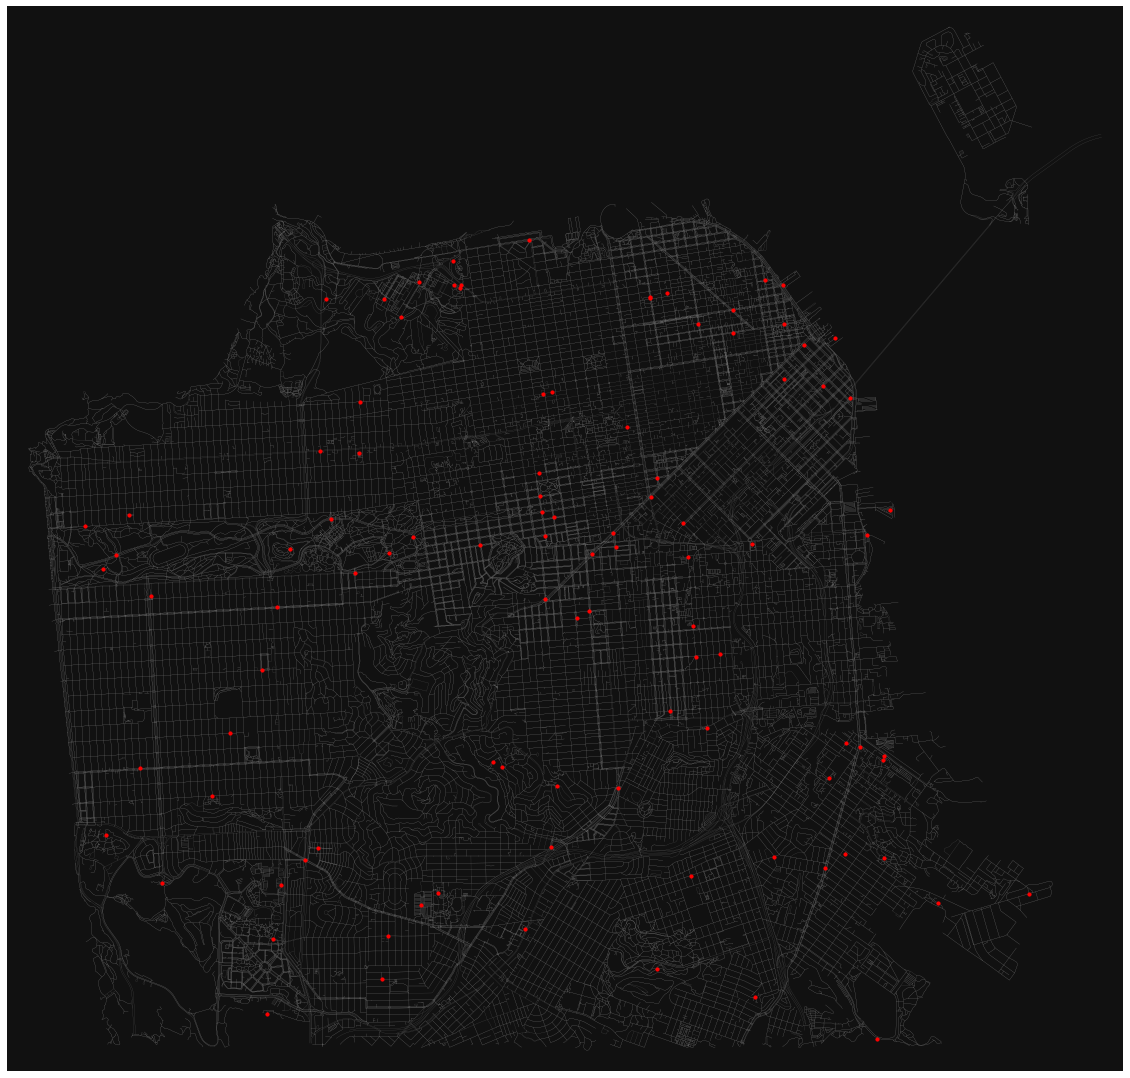

In [16]:
# ploteando los puntos
fig, ax = ox.plot_graph(G, 
                        node_size = 0, 
                        show=False,
                        close=False,
                        edge_linewidth  = 0.1,
                        figsize = (20, 20)
                       )


ax.scatter(
    [x_nodes[node_id] for node_id in origins_selected], 
    [y_nodes[node_id] for node_id in origins_selected], 
    c='red', 
    s = 10)


In [28]:
source_nodes_for_testing = []
radius_for_experiments = [10]

In [29]:
for index, origin_id in enumerate(origins_selected[:36]):
    print(f"########## INDEX {index+1} ########## ")
    
    source_node_object = SourceNode(node_id = origin_id, radius_experiments = radius_for_experiments)
    nodes_available_for_choicing = [node_id for node_id in G.nodes if node_id not in origins_selected]
    
    while not source_node_object.experiments_are_ready():
        possible_destiny_id = random.choice(nodes_available_for_choicing)

        if nx.has_path(G, origin_id, possible_destiny_id):
            for radius in radius_for_experiments:
                distance = radius * 1000
                distance_between_pair = distancia_entre_nodos(G, source_node_object.node_id, possible_destiny_id)

                if distance - 1000 < distance_between_pair <= distance and len(source_node_object.destinies_by_radius[radius]) < 4:
                    print(f"Radius is {radius} and distance was {distancia_entre_nodos(G, source_node_object.node_id, possible_destiny_id)}, lets insert this shit")
                    source_node_object.destinies_by_radius[radius].append(possible_destiny_id)
                    #print(source_node_object.destinies_by_radius)
                    continue

            nodes_available_for_choicing.remove(possible_destiny_id)
            
        elif index == 6:
            print(f"Cannot insert this, radius is {radius} and distance was {distancia_entre_nodos(G, source_node_object.node_id, possible_destiny_id)}")
                
            
        else:
            print(f"NO PATH BETWEEN {origin_id} AND {possible_destiny_id}")
            nodes_available_for_choicing.remove(possible_destiny_id)
    
    source_nodes_for_testing.append(source_node_object)

########## INDEX 1 ########## 
Radius is 10 and distance was 9800.962246940197, lets insert this shit
Radius is 10 and distance was 9332.74157430719, lets insert this shit
Radius is 10 and distance was 9321.843281812773, lets insert this shit
Radius is 10 and distance was 9217.546189970866, lets insert this shit
########## INDEX 2 ########## 
Radius is 10 and distance was 9036.966463770108, lets insert this shit
Radius is 10 and distance was 9758.329393298136, lets insert this shit
Radius is 10 and distance was 9507.676234901246, lets insert this shit
Radius is 10 and distance was 9508.07129375456, lets insert this shit
########## INDEX 3 ########## 
Radius is 10 and distance was 9488.135912848886, lets insert this shit
Radius is 10 and distance was 9015.716695163524, lets insert this shit
Radius is 10 and distance was 9755.119094170026, lets insert this shit
Radius is 10 and distance was 9600.717227726254, lets insert this shit
########## INDEX 4 ########## 
Radius is 10 and distance 

Radius is 10 and distance was 9754.056488866472, lets insert this shit
Radius is 10 and distance was 9230.626934552898, lets insert this shit
Radius is 10 and distance was 9782.208250391132, lets insert this shit
Radius is 10 and distance was 9443.23581804385, lets insert this shit
########## INDEX 27 ########## 
Radius is 10 and distance was 9656.553482080322, lets insert this shit
Radius is 10 and distance was 9226.509942860941, lets insert this shit
Radius is 10 and distance was 9922.836328957426, lets insert this shit
Radius is 10 and distance was 9424.838384286448, lets insert this shit
########## INDEX 28 ########## 
Radius is 10 and distance was 9075.701907047234, lets insert this shit
NO PATH BETWEEN 8416545245 AND 5860283549
NO PATH BETWEEN 8416545245 AND 3526885166
NO PATH BETWEEN 8416545245 AND 386885888
NO PATH BETWEEN 8416545245 AND 3964930931
Radius is 10 and distance was 9013.104243285637, lets insert this shit
NO PATH BETWEEN 8416545245 AND 6967308039
Radius is 10 and d

In [ ]:
#filehandler = open("./2800_experiment_source_node_object.pickle", 'wb') 
#pickle.dump(source_nodes_for_testing, filehandler)

In [ ]:
#infile = open('./2800_experiment_source_node_object.pickle','rb')
#experiments_list = pickle.load(infile)
#infile.close()

In [30]:
experiments_for_csv = []

for experiment in source_nodes_for_testing:
    source_id = experiment.node_id
    
    for category, destinies in experiment.destinies_by_radius.items():
        for destiny in destinies:
            experiments_for_csv.append(Experiment(source_id, destiny, category))

In [31]:
experiments_df = pd.DataFrame.from_records([e.__dict__ for e in experiments_for_csv])

In [32]:
experiments_df.to_csv("./experimentos/san_francisco_7131_experimentos_36_exp_10_km.csv", index=False)